# Use case - urban mobility
Recall the use case from the first class where we analyzed and visualized spatial distribution of urban population - residential and working. As we saw those tell pretty different stories and might not be well suited to represent urban activity at any given moment in time. 

Now consider a dataset with actual observations of such activity as seen through various data sources. The data contain cumulative number of 1) taxi+Uber pick-ups/drop-offs, 2) CitiBike pick-ups/drop-offs, 3) subway (MTA) extries and exits, 4) volume of 311 service requests, 5) cumulative activity in various mobile apps,  and 6) number of geo-tagged tweets. 

1)-4) is NYC open data, 5) is collected from http://skyhook.carto.com/ and 6) - scraped using Twitter Open API.

All data is aggregated temporally over one month of July, 2017 and spatially per taxi zone. It is also supplemented with the aggregated Census data reflecting amount and structure of residential population. 

**In this analysis we ask a question on what type of population contributes more to each type of activity - residential or working?**

More analysis using these data could be found in our recent pre-print at https://arxiv.org/abs/1809.01280

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#import all necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sbn
%matplotlib inline

In [0]:
#Upload the main dataset
SMdata=pd.read_csv("/content/gdrive/My Drive/Untitled folder/Socio-mobility.csv",index_col=0)

In [0]:
SMdata.head()

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,others,two_or_more,less_high_school,high_school,college,bachelor,graduate,median_income_households,median_income_families,median_income_nonfamily,mean_income_households,mean_income_families,mean_income_nonfamily,percent_below_poverty,unemployment_rate,percent_uninsured,mean_price_per_sqft,median_price_per_sqft,citibike_spatial,mobile-device_spatial,sr311_spatial,subway_spatial,taxi_spatial,twitter_spatial
tz,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,383102,0,0.0,95418,1546
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6348,0,0.0,73,44
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,21.494607,3.044684,20.748459,26.071178,28.830094,14.754546,9.595723,58999.68659,68423.31443,31895.21299,78914.24493,86548.96324,42915.01299,13.467371,10.045116,8.402712,318.691787,315.104167,0,109300,700,225527.5,31960,480
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,27.416488,4.417685,21.637927,21.197210,20.148902,27.568354,9.447606,43150.42329,45648.73956,44695.58889,67117.32603,71106.79636,63049.39407,31.590889,9.031957,8.955406,NaN,NaN,31545,179644,399,0.0,178515,85
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,1.291443,1.340533,7.779129,30.060812,30.167842,21.503284,10.488932,87056.58911,95815.28951,30256.87243,101280.59350,109982.19530,59388.70938,6.945072,5.503406,3.673850,289.552591,276.162791,0,56271,490,0.0,3667,40


In [0]:
#rename some of the columns for the sake of consistency and also to replace '-'
SMdata.rename(columns={'mobile-device_spatial':'mobile','citibike_spatial':'citibike','sr311_spatial':'sr311','subway_spatial':'subway','taxi_spatial':'taxi','twitter_spatial':'twitter'},inplace=True)

In [0]:
#also upload two other datasets from the last class - residential and working population
LEHDW=pd.read_csv("/content/gdrive/My Drive/Untitled folder/LEHD-work.csv",index_col=0)

In [0]:
#notice that residetial population here (from LEHD, based on the workforce residences) 
#is different from the one in the main dataset 
LEHDR=pd.read_csv("/content/gdrive/My Drive/Untitled folder/LEHD-resident.csv",index_col=0)

In [0]:
#merge the dataframes (inner merge on index - taxi zone number); take only the columns to use later
SMdata=SMdata[['population','mobile','citibike','sr311','subway','taxi','twitter']].merge(LEHDW[['total']].rename(columns={'total':'working'}), on=None, left_index=True, right_index=True, how='inner')

In [0]:
SMdata=SMdata.merge(LEHDR[['total']].rename(columns={'total':'residential'}), on=None, left_index=True, right_index=True, how='inner')

In [0]:
#glimpse into the final data
SMdata.head()

,population,mobile,citibike,sr311,subway,taxi,twitter,working,residential
tz,,,,,,,,,
3,32450.0,109300,0,700,225527.5,31960,480,4989,11398
4,27571.0,179644,31545,399,0.0,178515,85,2717,12318
5,26482.0,56271,0,490,0.0,3667,40,1191,10751
6,15896.0,147674,0,255,0.0,7456,88,2495,6729
7,77252.0,508255,0,1389,3336898.0,362180,2294,17223,43048


In [0]:
#get pair-wise column correlations
SMdata.corr()

,population,mobile,citibike,sr311,subway,taxi,twitter,working,residential
population,1.000000,0.670248,-0.210465,0.877397,-0.042691,-0.059860,-0.028276,-0.099852,0.969425
mobile,0.670248,1.000000,-0.066319,0.607098,0.219016,0.144768,0.214191,0.175743,0.646672
citibike,-0.210465,-0.066319,1.000000,-0.183276,0.486907,0.748109,0.372861,0.513090,-0.102762
sr311,0.877397,0.607098,-0.183276,1.000000,-0.010677,-0.026607,0.066799,-0.049597,0.865145
subway,-0.042691,0.219016,0.486907,-0.010677,1.000000,0.630203,0.496341,0.703456,0.020381
taxi,-0.059860,0.144768,0.748109,-0.026607,0.630203,1.000000,0.556061,0.720043,0.053496
twitter,-0.028276,0.214191,0.372861,0.066799,0.496341,0.556061,1.000000,0.626458,0.017787
working,-0.099852,0.175743,0.513090,-0.049597,0.703456,0.720043,0.626458,1.000000,-0.040786
residential,0.969425,0.646672,-0.102762,0.865145,0.020381,0.053496,0.017787,-0.040786,1.000000


But notice that some activities are not defined for the entire city. Would be more appropriate to correlate only where activity is defined

In [0]:
#auxiliary function to compute correlations between columns where both have data
def NZPopCorr(col1,col2):
    ind=(SMdata[col1]>0)&(SMdata[col2]>0)
    return np.corrcoef(SMdata[col1][ind],SMdata[col2][ind])[0][1]

In [0]:
#output a table with correlations between activities and population counts
PL=['population','residential','working']
ML=['taxi','subway','citibike','twitter','mobile','sr311']
pd.DataFrame([[NZPopCorr(M,P) for P in PL] for M in ML],columns=PL,index=ML) 

,population,residential,working
taxi,-0.064720,0.049633,0.719559
subway,-0.232504,-0.141712,0.720643
citibike,-0.126996,0.011210,0.319030
twitter,-0.032551,0.017787,0.626458
mobile,0.676604,0.646672,0.175743
sr311,0.869460,0.863358,-0.056116


So transportation activity and twitter are correlated more with working population, while mobile and 311 - with residential.

## Task 1. Visualize the heatmaps of all six activities and the populations 
Normalize by area and try log scale or uniform scale - whatever makes more visual sense. Also let's implement the visualization as a loop over a union of ML and PL lists above, rather than coding each visualization separately. 

In [0]:
#read shapefiles of NYC taxi zones
tzs=gpd.read_file('/content/gdrive/My Drive/Untitled folder/taxi_zones.shp')

In [0]:
tzs = tzs.merge(SMdata, left_on="LocationID", right_index= True)

In [0]:
tzs.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,population,mobile,citibike,sr311,subway,taxi,twitter,working,residential
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",32450.0,109300,0,700,225527.5,31960,480,4989,11398
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",27571.0,179644,31545,399,0.0,178515,85,2717,12318
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",26482.0,56271,0,490,0.0,3667,40,1191,10751
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, ...",15896.0,147674,0,255,0.0,7456,88,2495,6729
6,7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398,...",77252.0,508255,0,1389,3336898.0,362180,2294,17223,43048


/usr/local/lib/python2.7/dist-packages/geopandas/plotting.py:400: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


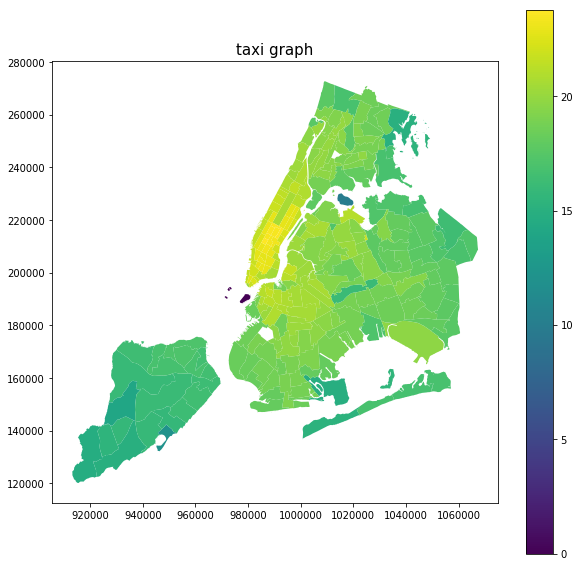

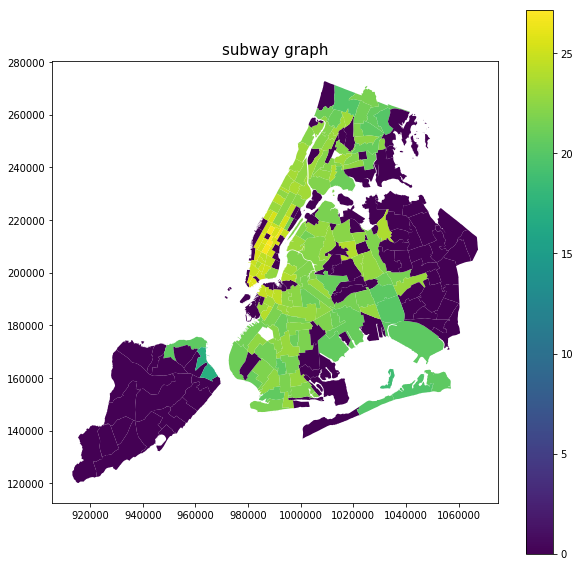

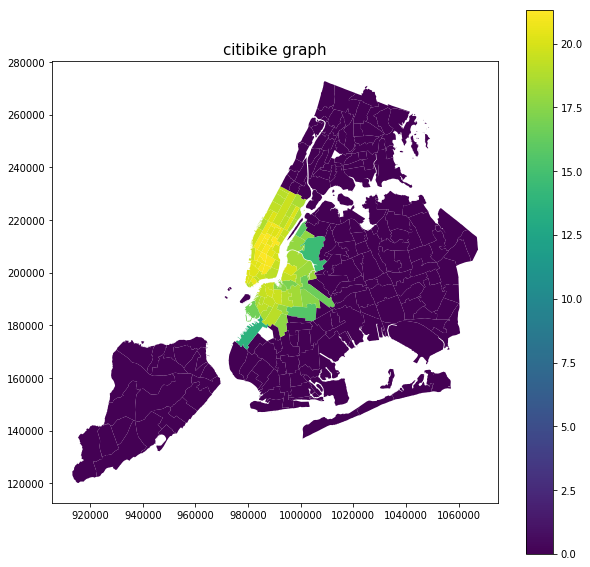

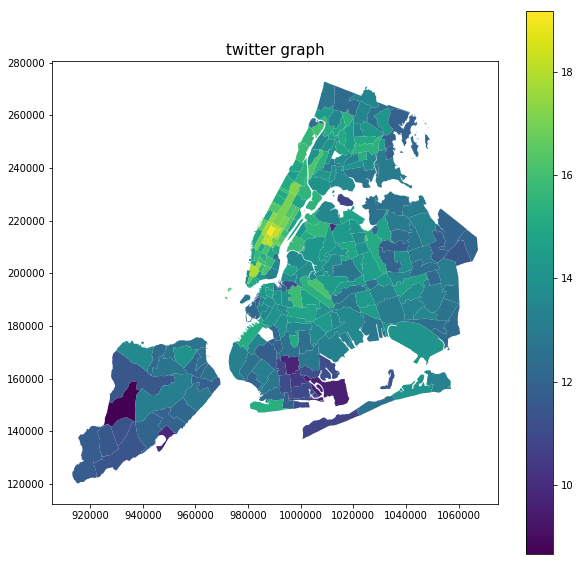

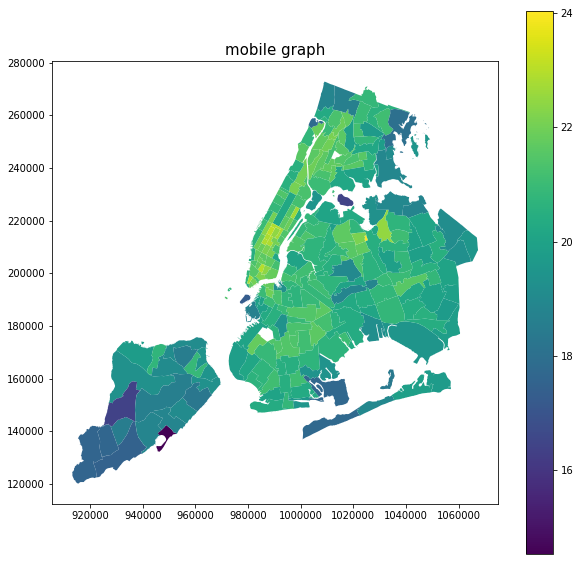

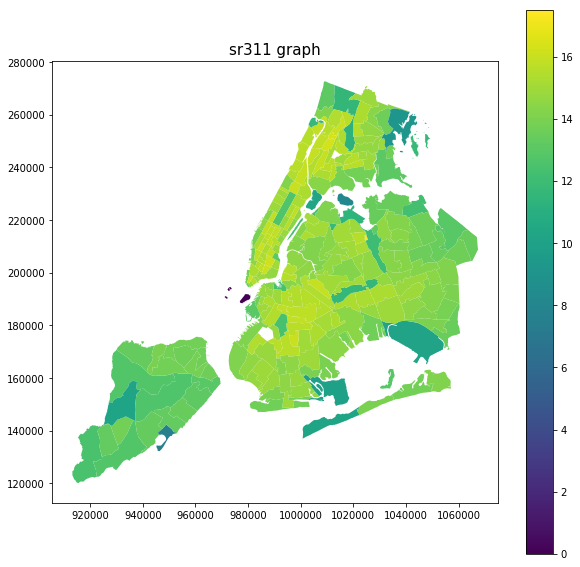

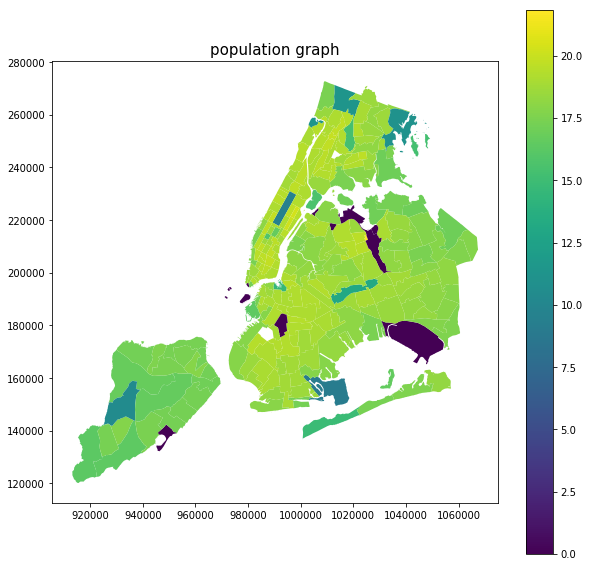

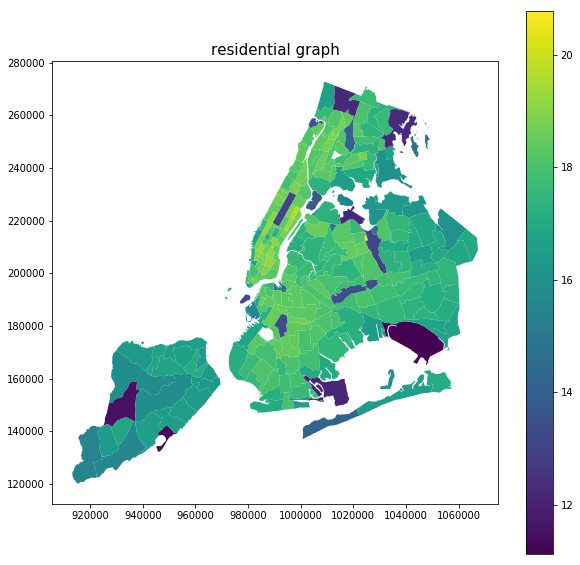

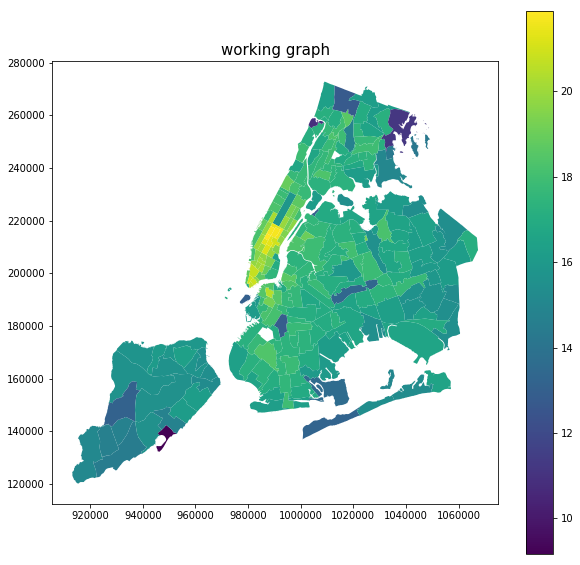

In [0]:
for item in ML+PL:
  tzs[item] = tzs[item]/tzs.Shape_Area
  tzs[item] = np.log1p(tzs[item])
  f, ax = plt.subplots(1, figsize = (10,10))
  ax.set_title(item+" graph", fontsize = 15)
  tzs.plot(axes = ax, column = item, legend = True)
